In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'styles.css'
HTML(open(css_file, "r").read())

In [2]:
#Header
import scipy
import scipy.integrate as integrate
import matplotlib as mpl
mpl.use("nbagg")
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.animation as animation


#this works apparently only for savefig stuff
mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=400             #72 
#mpl.rcParams['figure.subplot.bottom']=.1    #.125

plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('figure' , autolayout = True)

#inline stuff
#%matplotlib inline
# %config InlineBackend.figure_format='svg'
# inlineConf ={'figure.facecolor': 'white', 
#     'figure.subplot.bottom': 0.125,
#     'figure.edgecolor': 'white',
#     'savefig.dpi': 400, 
#     'figure.figsize': (12.0, 8.0), 
#     'font.size': 12}
# %config InlineBackend.rc = inlineConf

import numpy as np
from numpy.linalg import inv
from numpy import sin, cos, pi, mat, array
import time, copy
from IPython.display import Image
from IPython.core.debugger import set_trace

π = np.pi

# Simulating the Woodpecker Toy

Michael Baumann, Gabriel Nützi, July 2017
_________________________________________

**Simulation of the woodpecker toy
using Moreau's Timestepping scheme with SOR-prox method (for planar problems)**

Model: http://www.zfm.ethz.ch/~glocker/PublicationPDF/Conference%20Proceedings/bw_2001_ASME_Pittsburgh.pdf

<table style="background:#FFF;border-width:0pt;border-color:#AAAAAA;border-style:solid;">
    <tr style="background:#FFF;border-width:0pt;border-color:#AAAAAA;border-style:solid;">
    <td width="56%" style="background:#FFF;border-width:0pt;border-color:#AAAAAA;border-style:solid;">
        <img src="graphics/woodpecker_toy.bmp" style="width:100%;border-width:3pt;border-color:#AAAAAA;border-style:solid;"/>
    </td>
    <td style="background:#FFF;border-width:0pt;border-color:#AAAAAA;border-style:solid;">
        <img src="graphics/woodpecker_model.png" style="border-width:3pt;border-color:#AAAAAA;border-style:solid;"/>
    </td>
    <tr>
</table>
<!--div style="width:100%;text-align:center;">
        <img src="WoodpeckerAnimation2.svg" style="width:50%;border-width:3pt;border-color:#AAAAAA;border-style:solid;"/>
</div-->

## Point Class
A simple point class which is a (dim,nPoints) numpy.matrix where each column
can be additinally accessed by `self.<pointName>` for convenience!
```python
points      = Points(np.mat(np.ones((2,3))), names=["a","b","c"])
points.a    = points.b + points.c
points["a"] = points["b"] + points["c"] 
```

In [ ]:
class Points(np.matrixlib.defmatrix.matrix):
    def __new__(cls, *args, names=[], **kwargs):
        o = np.matrixlib.defmatrix.matrix.__new__(cls, *args, **kwargs)
        # We need to adjust here __class__
        # such that o is of type Points and the __init__ get
        # automatically called
        o.__class__ = Points
        return o
    
    def __init__(self, *args, names=[], **kwargs):
        assert(isinstance(names,list)) # Needs to be a list!
        # Set the attribute self.<pointName> 
        # to a reference of the corresponding column
        for i,name in enumerate(names):
            self.__setattr__(name, self[:,i])
            
        # Set the point indices, for the __setattr__
        self.__setattr__("pointIndices", {t:i for i,t in enumerate(names)})
        
    def __setitem__(self, name, val):
        """ This setter is needed for `self[<pointName>] = ...`  to work. """
        if isinstance(name,str) and hasattr(self, "pointIndices"):
            if name in self.pointIndices:
                self[:,self.pointIndices[name]] = val
                return
        super(Points, self).__setitem__(name, val)

    def __getitem__(self, *args, **kwargs):
        """ This setter is needed for getting points like `self[<pointName>]`"""
        if isinstance(args[0],str) and hasattr(self, args[0]):
            return getattr(self,args[0])
        return super(Points, self).__getitem__(*args, **kwargs)
    
    def __setattr__(self,name,val):
        """ This setter is needed, to make assignment work 
            (e.g self.<pointName> = np.mat([1,2,3]).T) 
            Without this setter: we would accidentally assign 
            self.<pointName> to a new object.
        """
        if hasattr(self, "pointIndices"):
            if name in self.pointIndices:
                self[:,self.pointIndices[name]] = val
                return
        super(Points, self).__setattr__(name,val)

## Class Woodpecker

In [4]:
class State:
    def __init__(self, q,u,t,PN,PT, γNA, γTA, γNE, γTE, IN=None):
        self.q   = q.copy()
        self.u   = u.copy()
        self.t   = t
        self.PN  = PN.copy()
        self.PT  = PT.copy()
        self.γNA = γNA.copy()
        self.γTA = γTA.copy()
        self.γNE = γNE.copy()
        self.γTE = γTE.copy()
        self.IN  = IN
        if self.IN is None:
            self.IN = [False]*PN.shape[0]
        
class Woodpecker:
    # initialization of class
    def __init__(self,q0,u0, pardict):
        q = np.mat(q0, dtype='float').T
        u = np.mat(u0, dtype='float').T
        t = 0
     
        self.qDim = len(q0);
        self.uDim = len(u0);
        
        # read all parameters from dictionary pardict and store as attribute in (self.)p
        self.p = type('Param', (), {})()
        for k,v in pardict.items():
            setattr(self.p,k,v)
            
        self.history = []
        
        self.nGZeros = zeros = mat(np.zeros(self.p.nG)).T
        
        γNE, γTE = self.getRelativeVelocities(q, u, t)
        
        # Push initial state
        self.history.append(State(q,u,t,PN=zeros,PT=zeros, γNA=zeros, γTA=zeros, γNE=γNE, γTE=γTE))
            
    # mass matrix
    def M(self,q,u,t):
        p=self.p # parameters
        y,ϕM,ϕS=q.A1 #gen coordinates
        yd,ϕMd,ϕSd=u.A1 # gen velocities
        return mat([(p.mS+p.mM, p.mS*p.lM, p.mS*p.lG),
                    (p.mS*p.lM, p.JM+p.mS*p.lM**2, p.mS*p.lM*p.lG),
                    (p.mS*p.lG, p.mS*p.lM*p.lG, p.JS+p.mS*p.lG**2)])
    
    # force vector
    def h(self,q,u,t):
        p=self.p # parameters
        y,ϕM,ϕS=q.A1 #gen coordinates
        yd,ϕMd,ϕSd=u.A1 # gen velocities
        return mat([-(p.mS+p.mM)*p.g,
                    -p.cϕ*(ϕM-ϕS)-p.mS*p.g*p.lM,
                    -p.cϕ*(ϕS-ϕM)-p.mS*p.g*p.lG]).T
    
    # gap function
    def gapFunction(self,q,u,t):
        p=self.p # parameters
        y,ϕM,ϕS=q.A1 #gen coordinates
        yd,ϕMd,ϕSd=u.A1 # gen velocities
        return mat([p.lM+p.lG-p.lS-p.r0-p.hS*ϕS,
                    p.rM-p.r0+p.hM*ϕM,
                    p.rM-p.r0-p.hM*ϕM]).T
    
    # force directions
    def Wmat(self,q,u,t):
        p=self.p # parameters
        y,ϕM,ϕS=q.A1 #gen coordinates
        yd,ϕMd,ϕSd=u.A1 # gen velocities
        
        #normal force directions
        WN = mat([(0, 0, 0),
                  (0, p.hM, -p.hM),
                  (-p.hS, 0, 0)])
        
        wNhat = mat([0,
                     0,
                     0]).T
    
        # tangential force directions
        WT = mat([(1, 1, 1),
                  (p.lM, p.rM, p.rM),
                  (p.lG-p.lS, 0, 0)])
        
        wThat = mat([0,
                     0,
                     0]).T
        
        return [WN,wNhat,WT,wThat]
    
    def getRelativeVelocities(self,q,u,t):
        return self._getRelativeVelocities(*self.Wmat(q,u,t), u)
        
    def _getRelativeVelocities(self,WN,wNhat,WT,wThat, u):
        γN = WN.T*u + wNhat
        γT = WT.T*u + wThat
        return γN, γT
    
    # compute integration step of lenght dt and update state    
    def step(self, dt):
        
        p = self.p # parameters
        
        stateA = self.history[-1]
        #start integration step
        qA = stateA.q
        uA = stateA.u
        tA = stateA.t
        
        #calculate midpoint
        qM = qA + dt/2*uA
        tM = tA+dt/2
        hM = self.h(qM,uA,tM)
        MM = self.M(qM,uA,tM)

        #calculate index set
        gNM = self.gapFunction(qM,uA,tM)
        IN = (gNM<=0).A1
        nN = np.count_nonzero(IN)
        
        Minv = MM.I # Invert Mass Matrix
        
        #solve contact problem and end integration step
        if nN>0:
            
            PN = mat(np.zeros(p.nG)).T
            PT = mat(np.zeros(p.nG)).T
        
            WN, wNhat, WT, wThat = self.Wmat(qM,uA,tM)
            WNs    = WN[:,IN]
            wNhats = wNhat[IN]
            WTs    = WT[:,IN]
            wThats = wThat[IN]
            
            μs  = p.μ[IN]
            GNN = WNs.T*Minv*WNs
            GNT = WNs.T*Minv*WTs
            GTN = WTs.T*Minv*WNs
            GTT = WTs.T*Minv*WTs
          
            rN = p.αr * np.reciprocal(np.diag(GNN))
            rT = p.αr * np.reciprocal(np.diag(GTT))
            
            γNA, γTA = self._getRelativeVelocities(WNs,wNhats,WTs,wThats,uA)
            
            cN = np.multiply(np.mat(1 + p.ɛN[IN]).T, γNA) + WNs.T*Minv*hM*dt
            cT = np.multiply(np.mat(1 + p.ɛT[IN]).T, γTA) + WTs.T*Minv*hM*dt
            
            PNs = PN[IN]
            PTs = PT[IN]
            converged=False 
            iter=0

            while not converged and iter<p.maxiter: #Gauss Seidel fixed point iteration
                PNs_old = copy.copy(PNs)
                PTs_old = copy.copy(PTs)
                for j in range(0,nN):
                    PNs[j] = proxCN(PNs[j] - rN[j]*(GNN[j,:]*PNs + GNT[j,:]*PTs + cN[j]))
                    PTs[j] = proxCT(PTs[j] - rT[j]*(GTN[j,:]*PNs + GTT[j,:]*PTs + cT[j]), μs[j]*PNs[j])
                errorN = np.abs(PNs_old-PNs)
                errorT = np.abs(PTs_old-PTs)
                error = np.max(np.hstack([errorN, errorT]),1)
                converged = np.all(error<p.atol)
                iter = iter+1
                
            PN[IN] = PNs #put the contact efforts of the closed contacts in the vector of all contact efforts
            PT[IN] = PTs
            uE = uA  + Minv*(hM*dt + WNs*PNs + WTs*PTs)
            
        else:  #all constacts are open
            uE = uA  + Minv*hM*dt
            converged = True
            error = 0

        if not converged:
            print('not converged')
        
        tE = tA + dt
        qE = qA + (uE+uA)*dt/2; # Symmetrix Update
        
        γNE, γTE = self.getRelativeVelocities(qE, uE, tE)
        
        if nN==0:
            PN = PT = γNA = γTA = self.nGZeros
            
        self.history.append(State(qE, uE, tE, PN, PT, γNA, γTA, γNE, γTE, IN))
    
    def getContactNames(self):
        return ["x1","x2","x3","x2opp","x3opp"]
    
    def getContactIndices(self):
        return [0,1,2,1,2];
    
    # compute x- and y-coordinates of points in the model figure above
    def position(self, q=None):
        # Make 2d-Punktarray (with each column as attribute name)
        # this is very neat!! :-)
        names = [*self.getContactNames(), "xG", "xS", "xP", "xM"]
        points = Points(np.mat(np.zeros(shape=(2,len(names)))), names= names)
        
        p = self.p
        if q is None:
            y,ϕM,ϕS = self.q # gen coordinate
        else:
            y,ϕM,ϕS = q # gen coordinate
                            
        points.xM = np.mat([0,y]).T
        
        rot = lambda ϕ: np.mat([[cos(ϕ), -sin(ϕ)],
                                [sin(ϕ), cos(ϕ)]])
        
        x2ref = np.mat([p.rM,-p.hM]).T
        x3ref = np.mat([p.rM,p.hM]).T
        
        points.x2 = rot(ϕM)*x2ref + points.xM
        points.x3 = rot(ϕM)*x3ref + points.xM
        
        points.x2opp = -rot(ϕM)*x2ref + points.xM
        points.x3opp = -rot(ϕM)*x3ref + points.xM
        
        xGref = np.mat([p.lM,0]).T
        xSref = np.mat([p.lG,0]).T
        xPref = np.mat([p.lG,p.hS]).T
        x1ref = np.mat([p.lG-p.lS,p.hS]).T
        
        points.xG = rot(ϕM)*xGref + points.xM
        points.xS = rot(ϕS)*xSref + points.xG
        points.xP = rot(ϕS)*xPref + points.xG
        points.x1 = rot(ϕS)*x1ref + points.xG
        
        return points
    
# proximal point function onto CN = R_0^+
def proxCN(x):
    return max(x,0)

# proximal point function onto CT = [-a,a]
def proxCT(x,a):
    return max(min(x,a),-a)

## Define Parameters for Model

In [5]:
# System parameters
# cφ is missing in the paper
pardict = {
    'mM' : 0.0003, #[kg]
    'JM' : 5e-9, #[kg m2]
    'mS' : 0.0045, #[kg]
    'JS' : 7e-7, #[kg m2]
    'g' : 9.81, #[m/s2]
    'cφ' : 0.0056, #[Nm/rad]
    'r0' : 0.0025, #[m]
    'rM' : 0.0031, #[m]
    'hM' : 0.0058, #[m]
    'lM' : 0.010, #[m]
    'lG' : 0.015, #[m]
    'hS' : 0.020, #[m]
    'lS' : 0.0201, #[m]
    'μ'  : np.array([0.3,0.3,0.3]), #[]
    'ɛN' : np.array([0.5,0,0]), #[]
    'ɛT' : np.array([0,0,0]), #[]
    'rtol' : 1e-7,
    'atol' : 1e-10,
    'maxiter' : 1000,
    'αr' : 0.9,
    'n' : 3, #number of states
    'nG' : 3 #number of contacts
}

#initial conditions
q0 = [0,-0.1036,-0.2788] #[y,φM,φS]
u0 = [-0.3411,0,-7.4583] #[yd,φMd,φSd]


## Simulate

In [6]:
# Simulation
N  = 1452+11    # Number of time steps
dt = 0.0001 # Timestep

mywoodpecker = Woodpecker(q0,u0,pardict)
for i in range(0,N):
    mywoodpecker.step(dt)

In [7]:
q = np.mat([state.q.A1 for state in mywoodpecker.history])
u = np.mat([state.u.A1 for state in mywoodpecker.history])
t = np.array([state.t  for state in mywoodpecker.history])
IN = np.mat([state.IN  for state in mywoodpecker.history])
γNE = np.mat([state.γNE.A1  for state in mywoodpecker.history])
γTE = np.mat([state.γTE.A1  for state in mywoodpecker.history])
PN = np.mat([state.PN.A1  for state in mywoodpecker.history])
PT = np.mat([state.PT.A1  for state in mywoodpecker.history])

## Plot Solution

<IPython.core.display.Javascript object>


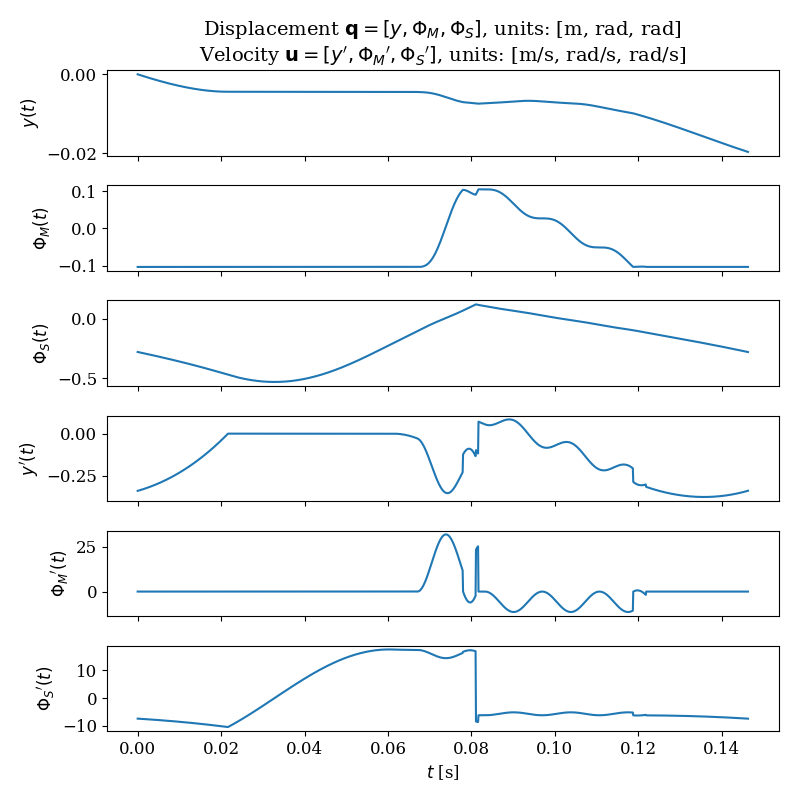

<IPython.core.display.Javascript object>


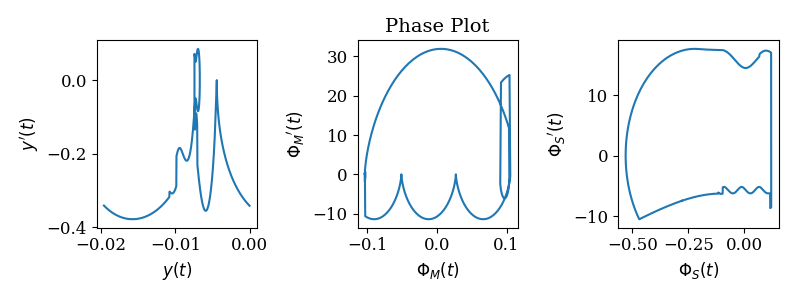

<IPython.core.display.Javascript object>


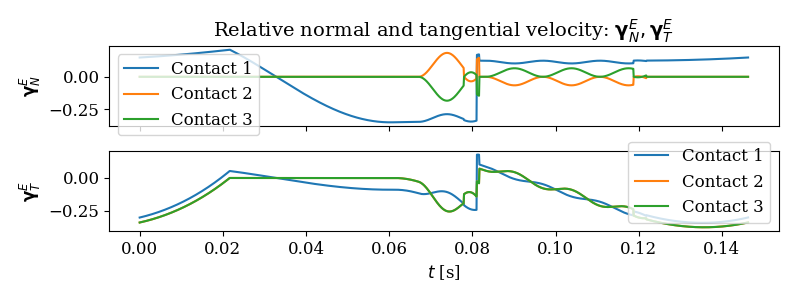

<IPython.core.display.Javascript object>


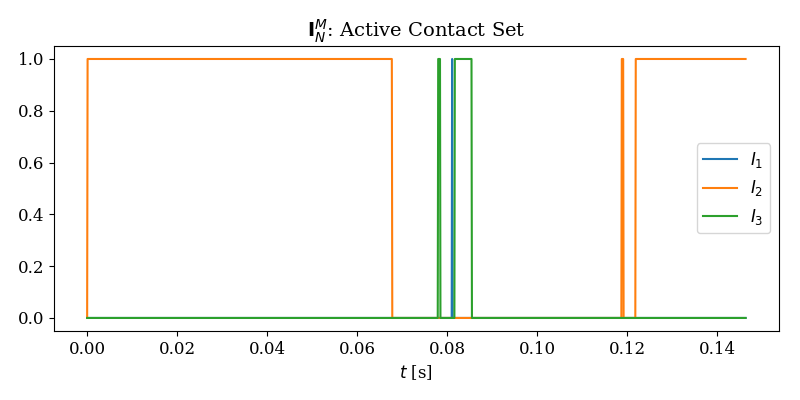

<IPython.core.display.Javascript object>


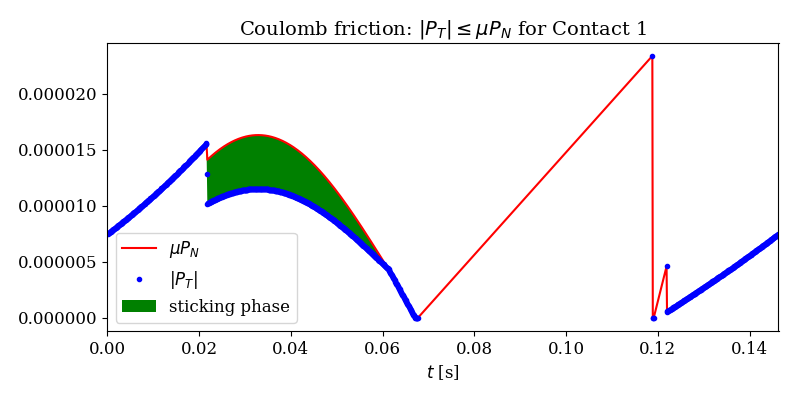

In [8]:
# Plotting
plt.close("all")
fig1,ax = plt.subplots(6, figsize=(8,8), sharex=True)

labelsQ = [r"$y(t)$",r"$\Phi_M(t)$", r"$\Phi_S(t)$"]
labelsU = [r"$y'(t)$",r"$\Phi_M{}'(t)$", r"$\Phi_S{}'(t)$"]

ax[0].set_title(r"Displacement $\mathbf{q} = [y,\Phi_M,\Phi_S]$, units: [m, rad, rad]"+"\n"+
               r"Velocity $\mathbf{u} = [y',\Phi_M{}',\Phi_S{}']$, units: [m/s, rad/s, rad/s]", 
              fontsize=14)
for i in range(0,3):
    ax[i].plot(t,q[:,i])
    ax[i].set_ylabel(labelsQ[i])
    ax[i+3].plot(t,u[:,i])
    ax[i+3].set_ylabel(labelsU[i])
ax[-1].set_xlabel(r"$t$ [s]")
fig1.tight_layout()

fig2,ax = plt.subplots(1,3, figsize=(8,3))
ax[1].set_title(r"Phase Plot",fontsize=14)
for i in range(0,3):
    ax[i].set_xlabel(labelsQ[i])
    ax[i].set_ylabel(labelsU[i])
    ax[i].plot(q[:,i],u[:,i])
fig2.tight_layout(pad=0.1)

fig3,ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
ax[0].set_title(r"Relative normal and tangential velocity: $\mathbf{\gamma}_N^E, \mathbf{\gamma}_T^E$",fontsize=14)
ax[0].plot(t, γNE)
ax[0].set_ylabel(r"$\mathbf{\gamma}_N^E$")
ax[1].plot(t, γTE)
ax[1].set_ylabel(r"$\mathbf{\gamma}_T^E$")
ax[0].legend([r"Contact 1", r"Contact 2", r"Contact 3"])
ax[1].legend([r"Contact 1", r"Contact 2", r"Contact 3"])
ax[-1].set_xlabel(r"$t$ [s]")
fig3.tight_layout(pad=0.1)

fig4,ax = plt.subplots(1, figsize=(8,4), sharex=True)
ax.set_title(r"$\mathbf{I}_N^M$: Active Contact Set",fontsize=14)
ax.plot(t, IN)
ax.set_xlabel(r"$\mathbf{I}_N^M$")
ax.legend([r"$I_1$",r"$I_2$",r"$I_3$"])
ax.set_xlabel(r"$t$ [s]")
fig3.tight_layout(pad=0.1)

fig4,ax = plt.subplots(1, figsize=(8,4), sharex=True)
contactIdx = 1
mask = IN[:,contactIdx].A1 # only where we have contact
ax.set_title(r"Coulomb friction: $|P_T| \leq \mu P_N$ for Contact %i" % contactIdx, fontsize=14)

maxTangentialForce = mywoodpecker.p.μ[contactIdx] * PN[mask,contactIdx]
tangentialForce    = np.abs(PT[mask,contactIdx])
ax.plot(t[mask], maxTangentialForce, "r")
ax.plot(t[mask], tangentialForce, "b.")
ax.fill_between(t[mask], tangentialForce.A1, maxTangentialForce.A1, 
                where=tangentialForce.A1 < maxTangentialForce.A1, facecolor='green', interpolate=True)
ax.set_xlim(t[0],t[-1])
ax.legend([r"$\mu P_N$",r"$|P_T|$","sticking phase"])
ax.set_xlabel(r"$t$ [s]")
fig4.tight_layout(pad=0.1)

plt.show()

## Animate Points

<IPython.core.display.Javascript object>


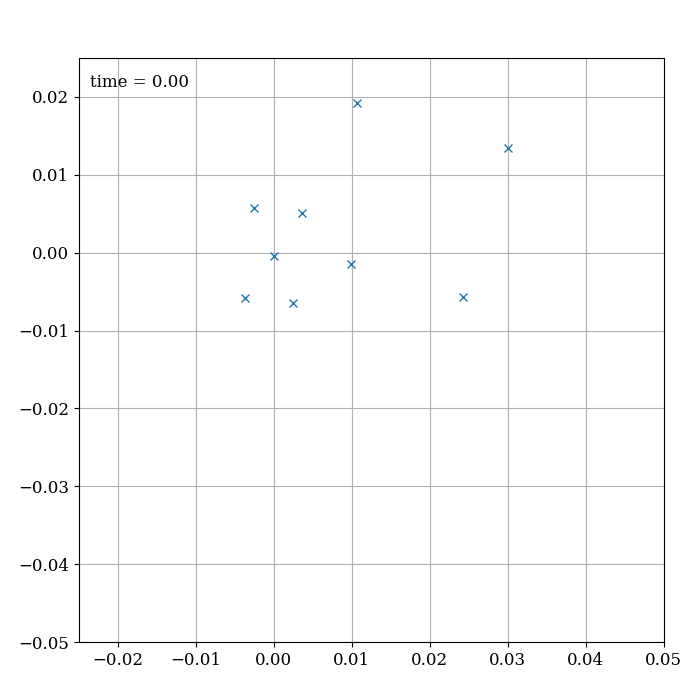

In [9]:
# Animate
speedUp = 25

q = np.mat([state.q.A1 for state in mywoodpecker.history])
t = np.array([state.t  for state in mywoodpecker.history])
N = len(t)

# setup figure, axis
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, aspect='equal', 
                     autoscale_on=False, xlim=(-0.025, 0.05), ylim=(-0.05, 0.025))
ax.grid()

# setup plot elements 
line, = ax.plot([], [], 'x')
time_template = 'time = %.1fs'
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

class AnimatorFunc:
    def __init__(self,mywoodpecker,line,time_text):
        self.mywoodpecker  = mywoodpecker
        self.line = line
        self.time_text = time_text
    
    def __call__(self,i):
        iFast = i*speedUp % N
        self.line.set_data(*mywoodpecker.position(q[iFast,:].A1))
        self.time_text.set_text('time = %.2f' % t[iFast])
        return self.line, self.time_text

animFunc = AnimatorFunc(mywoodpecker,line,time_text)

interval = 30

# call the animator.  blit=True means only re-draw the parts that have changed.
ani = animation.FuncAnimation(fig, animFunc, interval=interval, blit=False, init_func=None)
plt.show()

# SVG Animation
**Here we use a SVG template file, where we fill in the solution as `keytimes` and `values` into the `animateTransform` tag.**

In [10]:
# Simulate
N  = 4300   # Number of time steps
dt = 0.0001 # Timestep
mywoodpeckerSVG = Woodpecker(q0,u0,pardict)
for i in range(0,N):
    mywoodpeckerSVG.step(dt)

In [11]:
q  = np.mat([state.q.A1 for state in mywoodpeckerSVG.history])
u  = np.mat([state.u.A1 for state in mywoodpeckerSVG.history])
t  = np.array([state.t  for state in mywoodpeckerSVG.history])
PN = np.mat([state.PN.A1 for state in mywoodpeckerSVG.history])
PT = np.mat([state.PT.A1 for state in mywoodpeckerSVG.history])
IN = np.mat([state.IN for state in mywoodpeckerSVG.history])

## Prepare Timing Values for SVG Animation

In [12]:
# Compute timing values
maxFrameRate = 30 # We want max. 30 frames/s
speedUpPercentage = 2 # 100% means == realTime
nStates = len(t)
timeRange = np.array([np.min(t), np.max(t)])
print("Frame rate:", maxFrameRate)
print("Time range: ", timeRange)
print("Number of states: ", nStates)
print("Δt:", dt)

timeRangeAnimation = (timeRange / (0.01*speedUpPercentage)) - timeRange[0] # shift to [0,tEnd]
print("Time range animation: %0.2fs - %0.2fs" % tuple(timeRangeAnimation))
statesForAnimation = int(max(1, min((timeRangeAnimation[1] - timeRangeAnimation[0]) * maxFrameRate, nStates)))
print("Number of states (accord. to frameRate & speedUp): ", statesForAnimation)

Frame rate: 30
Time range:  [ 0.    0.43]
Number of states:  4301
Δt: 0.0001
Time range animation: 0.00s - 21.50s
Number of states (accord. to frameRate & speedUp):  644


## Interpolate Data

In [13]:
# Displacement q
tIp = np.linspace(timeRange[0],timeRange[1], statesForAnimation)
qIp = []
for i in range(0,mywoodpeckerSVG.qDim):
    qIp.append(np.interp(tIp, t, q[:,i].A1))
qIp = np.matrix(qIp).T

# Smoothing normal force PN at Contact 1 a little bit :-)
# To make it last longer in the animation
def runningMean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    cumsum = (cumsum[N:] - cumsum[:-N]) / N
    return cumsum
cIdx = mywoodpecker.getContactIndices()
N = 4*int(nStates / statesForAnimation)
if N > 1:
    plt.plot(t,PN[:,0])
    PNSmoothed = PN.copy()
    PTSmoothed = PT.copy()
    INSmoothed = IN.copy()
    print("Smooting PN with Average-Window: ", N)
    PNSmoothed[N-1:,0] = np.mat(runningMean(PN[:,0].A1 , N)).T
    PTSmoothed[N-1:,0] = np.mat(runningMean(PT[:,0].A1 , N)).T
    INSmoothed[N-1:,0] = np.mat(runningMean(INSmoothed[:,0].A1 , N)).T
    

PNIp = []
PTIp = []
INIp = []
for i in range(0,PN.shape[1]):
    PNIp.append(np.interp(tIp, t, PNSmoothed[:,i].A1))
    PTIp.append(np.interp(tIp, t, PTSmoothed[:,i].A1))
    INIp.append(np.interp(tIp, t, INSmoothed[:,i].A1))
PNIp = np.matrix(PNIp).T
PTIp = np.matrix(PTIp).T
INIp = np.matrix(INIp).T

maxNormalForce     = np.max(PNIp)
maxTangentialForce = np.max(PTIp)
print("Interpolated: Max Normal Force: ", maxNormalForce)
print("Interpolated: Max Tangential Force: ", maxTangentialForce)

# plt.figure("normalized PN")
# plt.plot(tIp,PNIp/maxNormalForce)
# plt.figure("normalized PT")
# plt.plot(tIp,PTIp/maxNormalForce);
# plt.figure("normalized IN")
# plt.plot(t,INSmoothed[:,0])

Smooting PN with Average-Window:  24
Interpolated: Max Normal Force:  5.78392535261e-05
Interpolated: Max Tangential Force:  1.73517760578e-05


## Load Template SVG

In [14]:
# Load XML
import lxml
from lxml import etree as ET
from lxml.builder import E

templateNr = 2
file = open("./graphics/WoodpeckerAnimationTemplate%i.svg" % templateNr,"r")
xmlDoc = ET.parse(file, parser=ET.XMLParser(remove_blank_text=True))
root = xmlDoc.getroot()

# Get all animateTransform nodes in the SVG
translateSleeve      = root.xpath('//*[@id="translateSleeve"]')[0]
rotateSleeve         = root.xpath('//*[@id="rotateSleeve"]')[0]
translateWoodpecker  = root.xpath('//*[@id="translateWoodpecker"]')[0]
rotateWoodpecker     = root.xpath('//*[@id="rotateWoodpecker"]')[0]
springPathAnimation  =  root.xpath('//*[@id="springPath"]')[0]
springForceAnimation =  root.xpath('//*[@id="springForce"]')[0]

# Add all forces to the XML
forceGroup = root.xpath('//*[@id="forces"]')[0]
forceNode  = root.xpath('//*[@id="force"]')[0]
contactForceNodes = {}
for c in mywoodpecker.getContactNames():
    id="PN-"+c
    contactForceNodes[id] = copy.deepcopy(forceNode)
    contactForceNodes[id].attrib["id"] = id
    forceGroup.append(contactForceNodes[id])
    id="PT-"+c
    contactForceNodes[id] = copy.deepcopy(forceNode)
    contactForceNodes[id].attrib["id"] = id
    forceGroup.append(contactForceNodes[id])
# Remove the forceTemplate Node
forceNode.getparent().remove(forceNode)
    
def forEach(f,n): 
    for i in n: f(i)
        
allNodes = [translateSleeve, rotateSleeve, translateWoodpecker, rotateWoodpecker, 
            springPathAnimation, springForceAnimation]

def setAnimationTiming(animateTransfNode, beginTime, endTime, keyTimes):
    animateTransfNode.attrib["begin"] = "0s"
    animateTransfNode.attrib["dur"] = "%ss" % (endTime - beginTime)
    animateTransfNode.attrib["repeatCount"] = "indefinite"
    animateTransfNode.attrib["calcMode"] = "linear"
    animateTransfNode.attrib["keyTimes"] = keyTimes
    if "from" in animateTransfNode.attrib:
        del animateTransfNode.attrib["from"]
    if "to" in animateTransfNode.attrib:
        del animateTransfNode.attrib["to"]

## SVG Export 
**Build `keytimes` $\in  [0,1]$ and corresponding `values` for all `animate`/`animateTransform` nodes and export the templated SVG.**

### Build `keyTimes` for all relevant nodes

In [15]:
# Building keyTimes
keyTimes   = ";".join(["%f" % t for t in np.linspace(0,1, statesForAnimation)])
print("keyTimes: ", keyTimes[0:50], "...")

# Adjust all timings of all animateTransform nodes
forEach(lambda n : setAnimationTiming(n, timeRangeAnimation[0], timeRangeAnimation[1], keyTimes), allNodes );

# Get important values for calculating transformations
rOG = np.hstack( [mywoodpeckerSVG.position(qIp[i,:].A1).xG for i in range(0,statesForAnimation)] )
rOS = np.hstack( [mywoodpeckerSVG.position(qIp[i,:].A1).xS for i in range(0,statesForAnimation)] )

y      = qIp[:,0].A1 # inverted
ϕM   = qIp[:,1].A1 # inverted angles in SVG
ϕS   = qIp[:,2].A1 # inverted angles in SVG
relϕ = ϕS - ϕM
maxAbsRelϕ = np.max(np.abs(relϕ))

def toSVGUnits(x):
    return x*1000;

def vec2SVG(x):
    x = x.copy() # copy
    x[1] *= -1    # y-axis is downwards
    return toSVGUnits(x).A1 # in [mm] 

keyTimes:  0.000000;0.001555;0.003110;0.004666;0.006221;0.007 ...


### Build `values` for the Woodpecker

In [16]:
# Building Values for Woodpecker 
################################
valuesTranslate = ";".join(["%f,%f" % tuple(vec2SVG(rOG[:,i])) for i in range(0,statesForAnimation)])
valuesRotate    = ";".join(["%f" % np.rad2deg(-ϕS[i]) for i in range(0,statesForAnimation)])
translateWoodpecker.attrib["values"] = valuesTranslate
rotateWoodpecker.attrib["values"]    = valuesRotate
print("Translate values Woodpecker: ", valuesTranslate[0:50], "...")
print("Rotate values Woodpecker: ", valuesRotate[0:50], "...")

Translate values Woodpecker:  9.946383,1.034148;9.946383,1.260625;9.946383,1.483 ...
Rotate values Woodpecker:  15.974063;16.261048;16.550487;16.842447;17.137014; ...


### Build `values` for the Sleeve

In [17]:
# Building Values for Sleeve
############################
valuesTranslate = ";".join(["%f,%f" % tuple(vec2SVG(np.mat([0,y[i]]).T)) for i in range(0,statesForAnimation)])
valuesRotate    = ";".join(["%f" % np.rad2deg(-ϕM[i]) for i in range(0,statesForAnimation)])
translateSleeve.attrib["values"] = valuesTranslate
rotateSleeve.attrib["values"]    = valuesRotate
print("Translate values Sleeve: ", valuesTranslate[0:50], "...")
print("Rotate values Sleeve: ", valuesRotate[0:50], "...")

Translate values Sleeve:  0.000000,0.000000;0.000000,0.226477;0.000000,0.449 ...
Rotate values Sleeve:  5.935843;5.935843;5.935843;5.935843;5.935844;5.935 ...


### Build `values` for the Spring

In [18]:
#Building Values for Spring [1mm]
################################
springRadius = 0.0015
def computeStartEndSpring(y, rOG, rOS, r):
    rGM = np.mat([0,y]).T - rOG
    rGS = rOS - rOG
    start = rGM / np.linalg.norm(rGM) * r + rOG
    end   = rGS / np.linalg.norm(rGS) * r + rOG
    return start, end

def makeSpringData(y, rOG, rOS, r = springRadius):
    start, end = computeStartEndSpring(y, rOG, rOS, r)
    s = vec2SVG(start)
    e = vec2SVG(end)
    r = toSVGUnits(r)
    # Move to start (M) and make absolute (A) elliptic arc 
    # with radius rx and ry (Arx,ry) till end pos
    return "M%f,%f A%f,%f 0 1,1 %f,%f" % (*s,r,r,*e) # for debugging A%f,%f 0 0,1 %f,%f  %(*s,*e)

def makeSpringForceValue(relϕ):
    # map relative angle to spring thickness
    return "%f" % ((np.abs(relϕ) / maxAbsRelϕ) * 0.4 + 0.3)

valuesSpringData= ";".join([makeSpringData(y[i], rOG[:,i], rOS[:,i]) for i in range(0,statesForAnimation)])
springPathAnimation.attrib["values"] = valuesSpringData

valuesSpringForce= ";".join([makeSpringForceValue(relϕ[i]) for i in range(0,statesForAnimation)])
springForceAnimation.attrib["values"] = valuesSpringForce

print("Path values Spring: ", valuesSpringData[0:50], "...")
print("Force values Spring: ", valuesSpringForce[0:50], "...")

Path values Spring:  M8.454426,0.879026 A1.500000,1.500000 0 1,1 11.388 ...
Force values Spring:  0.464276;0.468972;0.473709;0.478487;0.483307;0.488 ...


### Build `values` for the Percussions at each Contact 

In [19]:
# Building values for all Forces
################################

def makeContactForcesValue(contactName, rOC, force, normal=True):
    maxForceLength = 0.02    
    minForceLength = 0.001 # because of arrow tip which fluctuates
    s = vec2SVG(rOC)
    if normal:
        # horizontal
        l = toSVGUnits( maxForceLength * force/maxNormalForce + minForceLength ) 
        if "opp" in contactName:
            l *= -1 # opposite contact have opposite normal
        return "M%f,%f h%f" % (*s,l)
    else:
        l = toSVGUnits(maxForceLength * force/maxNormalForce + minForceLength)
        # vertical
        l *=-1 # y-axis is downwards
        return "M%f,%f v%f" % (*s,l)
    
def makeContactForcesActive(contactName, closed):
    if closed:
        return "inline"
    else:
        return "none"


for c,cIdx in zip(mywoodpeckerSVG.getContactNames(), mywoodpeckerSVG.getContactIndices()):
    print("Building Values for ContactIdx: %i and Point: %s" % (cIdx,c))
    
    valuesN = ";".join([makeContactForcesValue(c, mywoodpeckerSVG.position(qIp[i,:].A1)[c], PNIp[i,cIdx]) 
                        for i in range(0,statesForAnimation)])
    valuesT = ";".join([makeContactForcesValue(c, mywoodpeckerSVG.position(qIp[i,:].A1)[c], PTIp[i,cIdx], False) 
                        for i in range(0,statesForAnimation)])
    
    valuesActiveN = ";".join([makeContactForcesActive(c,INIp[i,cIdx]) for i in range(0,statesForAnimation)])
    
    # Normal Direction
    ##################
    # Path animation
    animatePathNode = E.animate(attributeName="d", values=valuesN)
    setAnimationTiming(animatePathNode, timeRangeAnimation[0], timeRangeAnimation[1], keyTimes)
    contactForceNodes["PN-"+c].append(animatePathNode)
    # Display (visible,hidden)
    animateDisplayNode = E.animate(attributeName="display", values=valuesActiveN)
    setAnimationTiming(animateDisplayNode, timeRangeAnimation[0], timeRangeAnimation[1], keyTimes)
    contactForceNodes["PN-"+c].append(animateDisplayNode)
    
    # Tangential Direction
    ######################
    animatePathNode = E.animate(attributeName="d", values=valuesT)
    setAnimationTiming(animatePathNode, timeRangeAnimation[0], timeRangeAnimation[1], keyTimes)
    contactForceNodes["PT-"+c].append(animatePathNode) 
    contactForceNodes["PT-"+c].append(copy.deepcopy(animateDisplayNode))

Building Values for ContactIdx: 0 and Point: x1
Building Values for ContactIdx: 1 and Point: x2
Building Values for ContactIdx: 2 and Point: x3
Building Values for ContactIdx: 1 and Point: x2opp
Building Values for ContactIdx: 2 and Point: x3opp


### Finally Export the XML

In [20]:
# Write XML
xmlDoc.write("WoodpeckerAnimation%i.svg" % templateNr, pretty_print=True, xml_declaration=True, encoding="utf-8")
print("XML written!")

XML written!


![](WoodpeckerAnimation2.svg)